<a href="https://colab.research.google.com/github/olfabre/amsProjetSemestre2/blob/main/10_05_mod%C3%A8le_avec_evaluation_fran%C3%A7ois.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entraînement sur le dataset de mots de passe...
 47s (1000 100%) 2.6282]


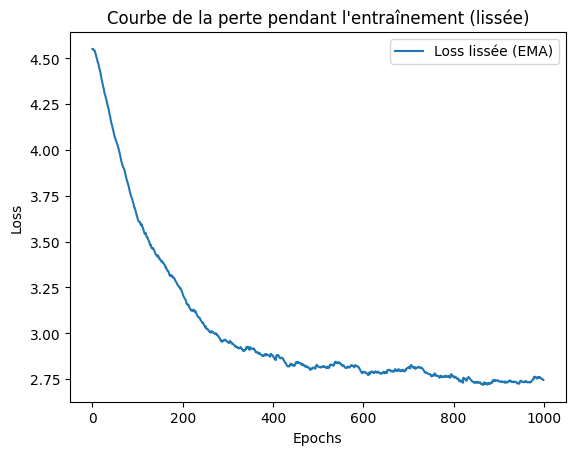

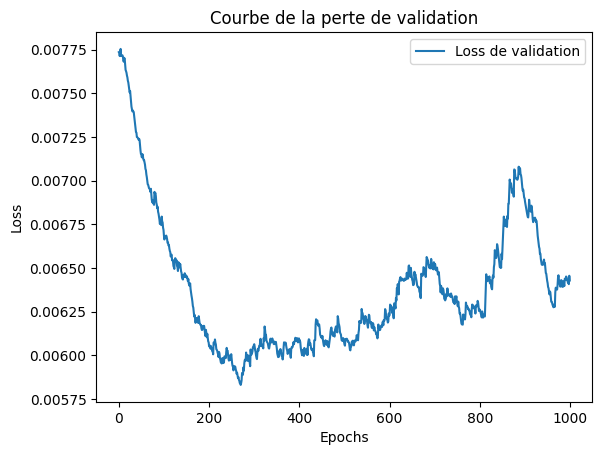

Génération de mots de passe après entraînement :
Cifammony
jel
ywoi9
3e3
bener0
Kgy
betilpeg169
E>
gicaond
F"t4


In [16]:
!pip install unidecode

import unidecode
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_characters = string.ascii_letters + string.digits + string.punctuation
selected = string.ascii_letters + string.digits
n_characters = len(all_characters)
n_characters_selected = len(selected)

chunk_len = 12

hidden_size = 256
n_layers = 2
lr = 0.005
n_epochs = 1000

train_file = unidecode.unidecode(open("sample_data/train2.txt").read())
train_file_len = len(train_file)
val_file = unidecode.unidecode(open("sample_data/validation2.txt").read())
val_file_len = len(val_file)

def random_chunk(file, file_len):
  start_index = random.randint(0, file_len - chunk_len - 1)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]

def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    if string[c] not in all_characters:
      continue
    tensor[c] = all_characters.index(string[c])
  return tensor.to(device)

def random_training_set(file, file_len):
  chunk = random_chunk(file, file_len)
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, dropout=0.3):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1

        self.encoder = nn.Embedding(input_size, hidden_size)

        # Passage de GRU à LSTM avec dropout
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers,
                            dropout=dropout if n_layers > 1 else 0.0,
                            bidirectional=self.bidirectional)

        # Ajout d’un bloc linéaire avec activation
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, input, hidden):
        embedded = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(embedded.view(1, 1, -1), hidden)
        output = self.fc(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        # LSTM retourne (h_0, c_0), donc il faut deux tenseurs
        h_0 = torch.zeros(self.n_layers * self.num_directions, 1, self.hidden_size, device=device)
        c_0 = torch.zeros(self.n_layers * self.num_directions, 1, self.hidden_size, device=device)
        return (h_0, c_0)



def train(inp, target):
  hidden = decoder.init_hidden()
  decoder.zero_grad()
  loss = 0
  seq_len = inp.size(0) # Récupérer la longueur du batch actuel
  for c in range(seq_len):
    output, hidden = decoder(inp[c], hidden)
    loss += criterion(output, target[c].unsqueeze(0))
  loss.backward()
  optimizer.step()
  train_losses.append(loss.item() / seq_len)
  return loss.item() / seq_len


def evaluate(prime_str='A', predict_len=25, temperature=0.8):
  if predict_len is None:
    predict_len = random.randint(5, 12)

  hidden = decoder.init_hidden()
  prime_input = char_tensor(prime_str)
  predicted = prime_str

  for p in range(len(prime_str) - 1):
    _, hidden = decoder(prime_input[p], hidden)
  inp = prime_input[-1]

  for _ in range(predict_len):
    output, hidden = decoder(inp, hidden)
    output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
    top_i = torch.multinomial(output_dist[:len(all_characters)], 1)[0]
    predicted_char = all_characters[top_i]

    if predicted_char == '&':
      break

    predicted += predicted_char
    inp = torch.tensor([all_characters.index(predicted_char)]).to(device)

  return predicted


def time_since(since):
  s = time.time() - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def exponential_moving_average(values, alpha=0.01):
  ema = []
  avg = values[0] # Initialisation
  for value in values:
    avg = alpha * value + (1 - alpha) * avg
    ema.append(avg)
  return ema

def evaluate_loss(n_samples=1000):
  total_loss = 0
  for _ in range(n_samples):
    inp, target = random_training_set(val_file, val_file_len)
    hidden = decoder.init_hidden()
    loss = 0
  for c in range(inp.size(0)):
    output, hidden = decoder(inp[c], hidden)
  loss += criterion(output, target[c].unsqueeze(0))
  total_loss += loss.item() / inp.size(0)
  return total_loss / n_samples

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
eval_losses = []
print("Entraînement sur le dataset de mots de passe...")

start = time.time()
for epoch in range(1, n_epochs + 1):
  loss = train(*random_training_set(train_file, train_file_len))
  with torch.no_grad():
    eval_loss = evaluate_loss(n_samples=50)
    eval_losses.append(eval_loss)
  if epoch % 1000 == 0:
    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

smoothed_train_losses = exponential_moving_average(train_losses, alpha=0.01)
smoothed_eval_losses = exponential_moving_average(eval_losses, alpha=0.01)

plt.plot(smoothed_train_losses, label='Loss lissée (EMA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte pendant l\'entraînement (lissée)')
plt.legend()
plt.show()

plt.plot(smoothed_eval_losses, label='Loss de validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte de validation')
plt.legend()
plt.show()

# save

if not path.exists("models"):
  makedirs("models")
torch.save(decoder, f"models/password_rnn_55.pt")

print("Génération de mots de passe après entraînement :")
for _ in range(10):
  print(evaluate(prime_str=random.choice(selected), temperature=0.7))

✅ Modèle chargé avec succès !

📊 Résultats de la validation sur 500 échantillons :
   - Validation Loss : 3.5557
   - Validation Accuracy : 0.30%


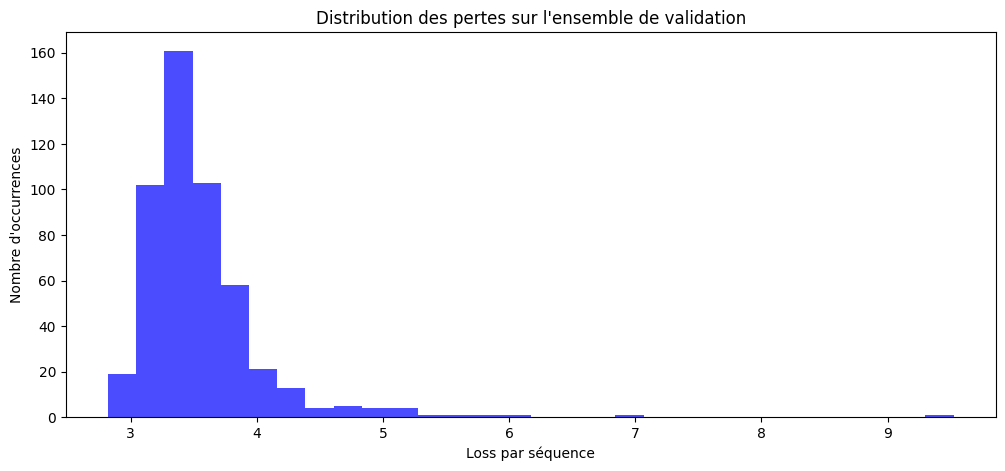

1 mots de passe générés.
101 mots de passe générés.
201 mots de passe générés.
301 mots de passe générés.
401 mots de passe générés.
501 mots de passe générés.
601 mots de passe générés.
701 mots de passe générés.
801 mots de passe générés.
901 mots de passe générés.

📊 Évaluation pendant génération :
   - Moyenne Loss : 2.7250
   - Accuracy     : 0.99%


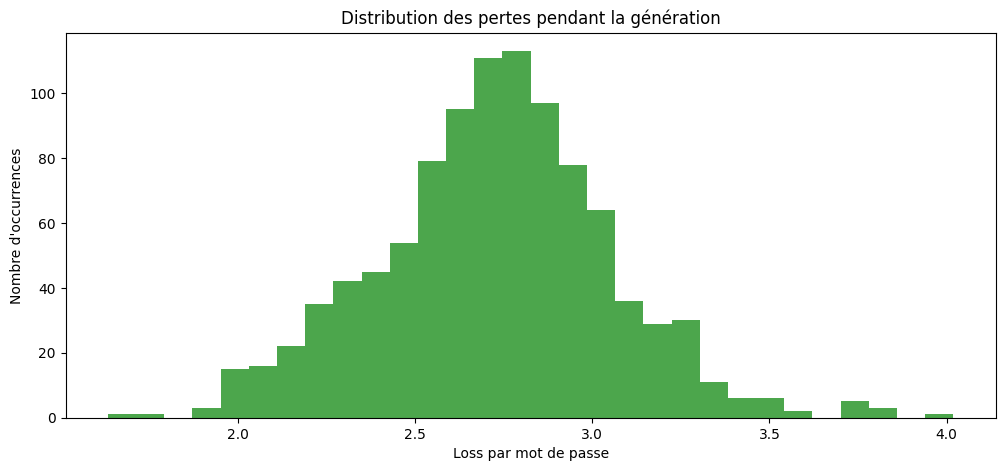

✅ 1000 mots de passe sauvegardés dans : passwords_1000.txt


In [11]:
!pip install unidecode

import unidecode
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, dropout=0.3):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1

        self.encoder = nn.Embedding(input_size, hidden_size)

        # Passage de GRU à LSTM avec dropout
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers,
                            dropout=dropout if n_layers > 1 else 0.0,
                            bidirectional=self.bidirectional)

        # Ajout d’un bloc linéaire avec activation
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, input, hidden):
        embedded = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(embedded.view(1, 1, -1), hidden)
        output = self.fc(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        # LSTM retourne (h_0, c_0), donc il faut deux tenseurs
        h_0 = torch.zeros(self.n_layers * self.num_directions, 1, self.hidden_size, device=device)
        c_0 = torch.zeros(self.n_layers * self.num_directions, 1, self.hidden_size, device=device)
        return (h_0, c_0)


# Charger le modèle entraîné
if path.exists("models/password_rnn_55.pt"):
    decoder = torch.load("models/password_rnn_55.pt", weights_only=False).to(device)
    decoder.eval()  # Mettre le modèle en mode évaluation
    print("✅ Modèle chargé avec succès !")
else:
    print("❌ Erreur : modèle introuvable.")
    exit()

# Charger les données de validation
try:
    val_file = unidecode.unidecode(open("sample_data/test2.txt").read())
    val_file_len = len(val_file)
except FileNotFoundError:
    print("❌ Erreur : Le fichier test2.txt est introuvable.")
    exit()

# Paramètres globaux
chunk_len = 12
all_characters = string.ascii_letters + string.digits + string.punctuation
selected = string.ascii_letters + string.digits
n_characters = len(all_characters)
n_characters_selected = len(selected)
hidden_size = 256
n_layers = 2
lr = 0.005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonction pour transformer un texte en tenseur de caractères
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        if string[c] not in all_characters:
            continue
        tensor[c] = all_characters.index(string[c])
    return tensor.to(device)

# Fonction pour obtenir un batch de validation
def validation_set():
    start_index = random.randint(0, val_file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = val_file[start_index:end_index]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Fonction d'évaluation
def evaluate_model(num_samples=100):
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []

    with torch.no_grad():
        for _ in range(num_samples):
            inp, target = validation_set()
            hidden = decoder.init_hidden()
            loss = 0
            seq_len = inp.size(0)

            for c in range(seq_len):
                output, hidden = decoder(inp[c].unsqueeze(0), hidden)
                loss += criterion(output, target[c].unsqueeze(0))

                # Calcul de l'accuracy
                pred = output.argmax(dim=1)
                correct += (pred == target[c]).sum().item()
                total += 1

            loss = loss.item() / seq_len
            total_loss += loss
            all_losses.append(loss)

    avg_loss = total_loss / num_samples
    accuracy = correct / total * 100

    return avg_loss, accuracy, all_losses

# Fonction pour générer un mot de passe
def evaluate(prime_str='A', predict_len=25, temperature=0.8):
    if predict_len is None:
        predict_len = random.randint(5, 12)

    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]

    for _ in range(predict_len):
        output, hidden = decoder(inp, hidden)
        output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
        top_i = torch.multinomial(output_dist[:len(all_characters)], 1)[0]
        predicted_char = all_characters[top_i]

        if predicted_char == '&':
            break

        predicted += predicted_char
        inp = torch.tensor([all_characters.index(predicted_char)]).to(device)

    return predicted

# Exécuter l'évaluation
criterion = nn.CrossEntropyLoss()
val_loss, val_accuracy, all_losses = evaluate_model(num_samples=500)

print(f"\n📊 Résultats de la validation sur 500 échantillons :")
print(f"   - Validation Loss : {val_loss:.4f}")
print(f"   - Validation Accuracy : {val_accuracy:.2f}%")

# Affichage graphique des pertes
plt.figure(figsize=(12, 5))
plt.hist(all_losses, bins=30, color="blue", alpha=0.7)
plt.xlabel("Loss par séquence")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des pertes sur l'ensemble de validation")
plt.show()

# Générer et sauvegarder des mots de passe après l'évaluation
def generate_passwords(n=100, min_len=6, max_len=11, temperature=0.7):
    passwords = []
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []

    for i in range(n):
        while True:
            prime_char = random.choice(selected)
            hidden = decoder.init_hidden()
            prime_input = char_tensor(prime_char)
            predicted = prime_char
            loss = 0

            # Initialisation
            inp = prime_input[0]
            password_target = ""

            for _ in range(max_len):  # Générer jusqu'à max_len
                output, hidden = decoder(inp, hidden)
                output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
                top_i = torch.multinomial(output_dist[:len(all_characters)], 1)[0]
                predicted_char = all_characters[top_i]

                if predicted_char == '&':
                    break

                predicted += predicted_char
                password_target += predicted_char

                # Préparer la prochaine entrée
                target_idx = torch.tensor([all_characters.index(predicted_char)]).to(device)

                loss += criterion(output, target_idx)
                pred_idx = output.argmax(dim=1)
                correct += (pred_idx == target_idx).sum().item()
                total += 1

                inp = target_idx  # La prédiction devient l’entrée suivante

            # Vérifie la longueur
            if min_len <= len(predicted) <= max_len:
                passwords.append(predicted)
                total_loss += loss.item() / len(predicted)
                all_losses.append(loss.item() / len(predicted))
                break

        if i % 100 == 0:
            print(f"{i + 1} mots de passe générés.")

    avg_loss = total_loss / n
    accuracy = correct / total * 100
    print(f"\n📊 Évaluation pendant génération :")
    print(f"   - Moyenne Loss : {avg_loss:.4f}")
    print(f"   - Accuracy     : {accuracy:.2f}%")

    # Affichage histogramme
    plt.figure(figsize=(12, 5))
    plt.hist(all_losses, bins=30, color="green", alpha=0.7)
    plt.xlabel("Loss par mot de passe")
    plt.ylabel("Nombre d'occurrences")
    plt.title("Distribution des pertes pendant la génération")
    plt.show()

    output_path = f"passwords_{n}.txt"
    with open(output_path, "w") as f:
        for pwd in passwords:
            f.write(pwd + "\n")

    print(f"✅ {n} mots de passe sauvegardés dans : {output_path}")



generated_passwords = generate_passwords(n=1000)


